# Demo code for Flow Matching


The code has been adpoted from the following link: https://github.com/dome272/Flow-Matching/blob/main/flow-matching.ipynb 
However, I believe that that code is not correct, in the training phase.

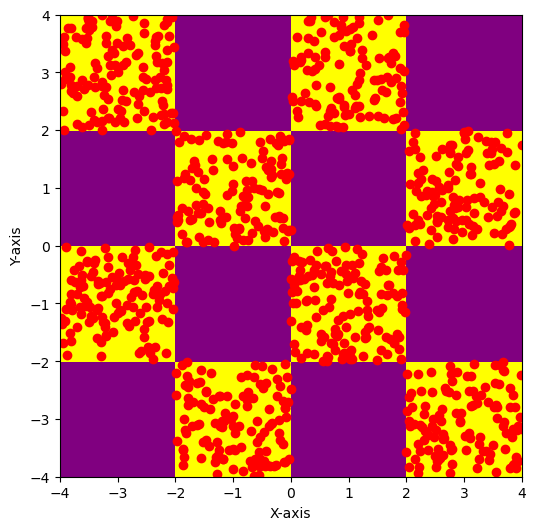

In [78]:
import tqdm
import math
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Parameters
N = 1000  # Number of points to sample
x_min, x_max = -4, 4
y_min, y_max = -4, 4
resolution = 100  # Resolution of the grid

# Create the grid
x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x, y)

# Checkerboard pattern
length = 4
checkerboard = np.indices((length, length)).sum(axis=0) % 2

# Sample points in regions where checkerboard pattern is 1
sampled_points = []
while len(sampled_points) < N:
    # Randomly sample a point within the x and y range
    x_sample = np.random.uniform(x_min, x_max)
    y_sample = np.random.uniform(y_min, y_max)
    
    # Determine the closest grid index
    i = int((x_sample - x_min) / (x_max - x_min) * length)
    j = int((y_sample - y_min) / (y_max - y_min) * length)
    
    # Check if the sampled point is in a region where checkerboard == 1
    if checkerboard[j, i] == 1:
        sampled_points.append((x_sample, y_sample))

# Convert to NumPy array for easier plotting
sampled_points = np.array(sampled_points)

# Plot the checkerboard pattern
plt.figure(figsize=(6, 6))
plt.imshow(checkerboard, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap=ListedColormap(["purple", "yellow"]))

# Plot sampled points
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

## Model

In [114]:
import math
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[Block(channels) for _ in range(layers)])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10_000):
        """
        Generates sinusoidal time embeddings.
        t: (batch, 1) tensor of time steps.
        Returns: (batch, channels_t) tensor.
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1) # Ensure shape (batch, 1)
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb_scale = math.log(float(max_positions) + 1e-8) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device, dtype=torch.float32) * -emb_scale)
        emb = t * emb  # (batch, half_dim)

        # Compute sinusoidal embeddings
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)  # (batch, channels_t)
        
        # If channels_t is odd, pad the embedding with zero
        if self.channels_t % 2 == 1:
            emb = nn.functional.pad(emb, (0, 1), mode='constant', value=0)
        
        return emb

    def forward(self, x, t):
        """
        Forward pass of MLP.
        x: (batch, channels_data) input data.
        t: (batch, 1) time step input.
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1)  # Ensure shape (batch, 1)

        x = self.in_projection(x)  # (batch, channels)
        t_emb = self.gen_t_embedding(t)  # (batch, channels_t)
        t_emb = self.t_projection(t_emb)  # (batch, channels)

        x = x + t_emb  # Combine time and input embeddings
        x = self.blocks(x)
        x = self.out_projection(x)  # (batch, channels_data)

        return x

## Training 

## Training as I understand it

In [ ]:
import torch
import tqdm

# Constants
SIGMA_MIN = 1e-3
TRAINING_STEPS = 10_000
BATCH_SIZE = 64
LEARNING_RATE = 1e-4

# Initialize model and optimizer
model = MLP(layers=5, channels=512)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Load data
data = torch.Tensor(sampled_points)

# Training loop
losses = []
pbar = tqdm.tqdm(range(TRAINING_STEPS), desc="Training Progress")

for _ in pbar:
    # Sample batch
    indices = torch.randint(data.size(0), (BATCH_SIZE,))
    x1 = data[indices]  # Shape: (BATCH_SIZE, data_dim)
    t = torch.rand(BATCH_SIZE, 1, device=x1.device)  # t ~ Uniform(0,1), Shape: (BATCH_SIZE, 1)
    mu = x1 * t  # Shape: (BATCH_SIZE, data_dim)
    sigma = 1 - (1 - SIGMA_MIN) * t  # Shape: (BATCH_SIZE, data_dim)
    x_t = mu + sigma * torch.randn_like(mu)  # x_t ~ N(mu, sigma^2) Shape: (BATCH_SIZE, data_dim)
    u_t = (x1 - (1 - SIGMA_MIN) * x_t) / (1 - (1 - SIGMA_MIN) * t)  # Target velocity
    # Model should predict the Target velocity
    pred = model(x_t, t) # Shape: (BATCH_SIZE, data_dim)
    loss = ((u_t - pred) ** 2).mean()

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Logging
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

Training Progress: 100%|██████████| 10000/10000 [00:38<00:00, 260.04it/s, loss=3.77]


### Showing the training phase

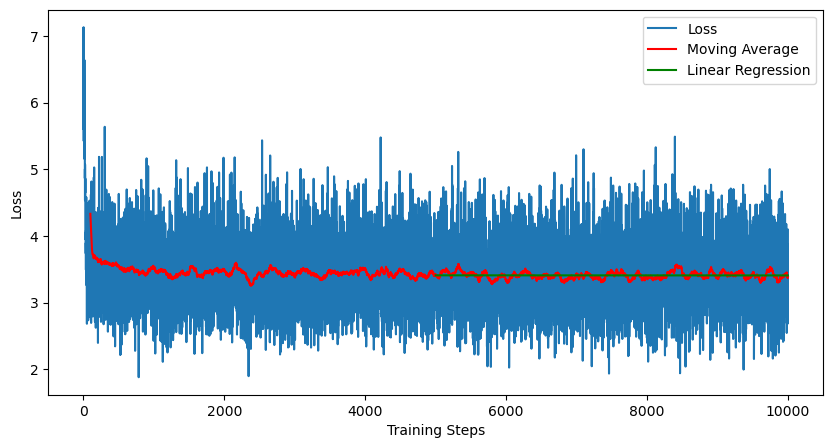

array([-3.28468575e-07])

In [94]:
from sklearn.linear_model import LinearRegression

# Calculate moving average
window_size = 100
losses_series = pd.Series(losses)
moving_avg = losses_series.rolling(window=window_size).mean()

# Plot the losses and moving average
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.plot(moving_avg, label='Moving Average', color='red')

# Linear regression on the last 50% of the iterations
half_index = len(losses) // 2
x_vals = np.arange(half_index, len(losses)).reshape(-1, 1)
y_vals = losses[half_index:]

reg = LinearRegression().fit(x_vals, y_vals)
y_pred = reg.predict(x_vals)

plt.plot(x_vals, y_pred, label='Linear Regression', color='green')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()
reg.coef_

### Using Learned Velocity $v_t(x)$  

We now start with a set of particles $x_0 \sim \mathcal{N}(0, I)$ and evolve them by following the learned velocity field $v_t(x)$.  

Since the particles have **no mass or inertia**, they **immediately adjust** to the local velocity $v_t(x)$ at each step. This means that instead of having acceleration or momentum, they are simply carried along by the flow:  

$$
x_t = x_{t-1} + \delta \cdot v_t(x_{t-1}) 
$$

where $\delta = \frac{1}{\texttt{steps}}$ is a small time increment. This describes a process, where each particle moves exactly in the direction of the velocity field at every moment.  

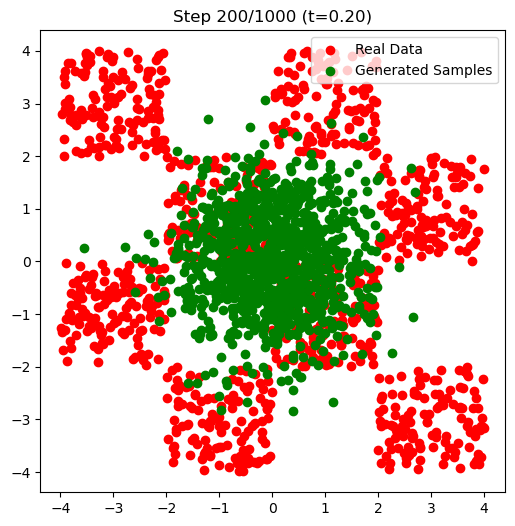

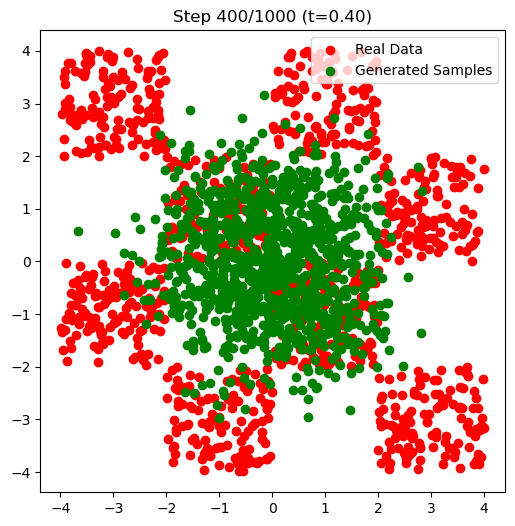

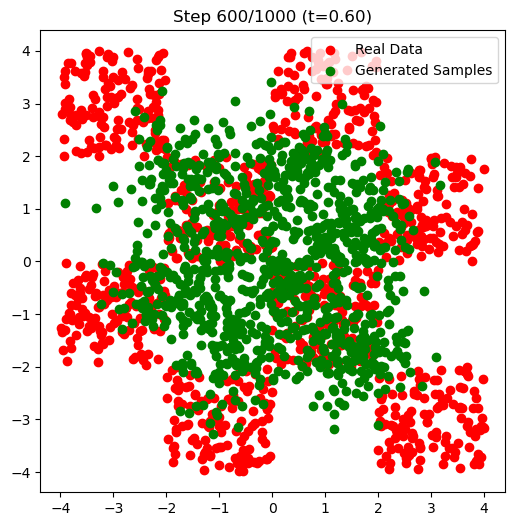

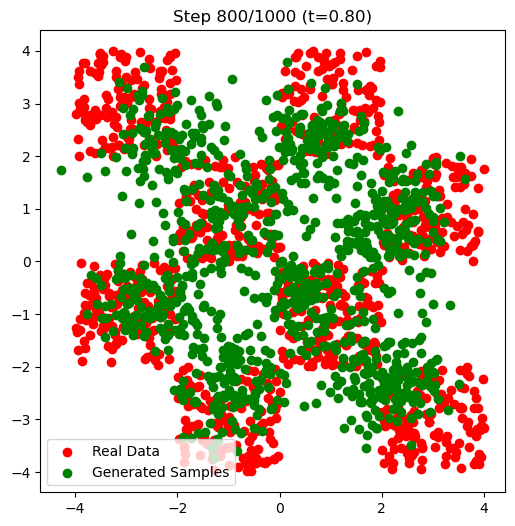

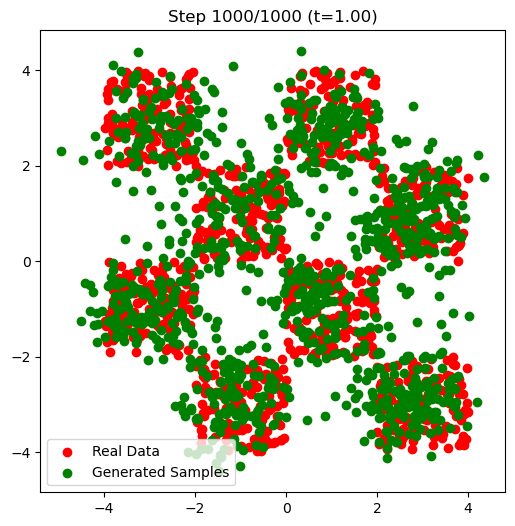

Done Sampling


In [ ]:
import torch
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Set model to evaluation mode and disable gradient computation
model.eval()

# Initialize samples from a normal distribution
xt = torch.randn(1000, 2)

# Number of integration steps
steps = 1000
plot_every = 200

with torch.no_grad():
    for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
        t = t.view(-1, 1).expand(xt.size(0), 1)  # Ensure (batch, 1) shape
        pred = model(xt, t)  # Predict velocity
        xt = xt + (1 / steps) * pred  
        
        # Plot results at intervals
        if i % plot_every == 0:
            plt.figure(figsize=(6, 6))
            plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o", label="Real Data")
            plt.scatter(xt[:, 0], xt[:, 1], color="green", marker="o", label="Generated Samples")
            plt.title(f"Step {i}/{steps} (t={t.mean().item():.2f})")
            plt.legend()
            plt.show()

# Restore model to training mode
model.train()
print("Done Sampling")


## Better Integration

A better integration of the flow improves numerical stability and reduces discretization errors. Instead of using Euler integration (the methods above), which follows the simple update rule $x_t = x_{t-1} + \delta \cdot v_t(x_{t-1})$,

we can use higher-order numerical methods for more accurate trajectory reconstruction. These methods are available in Torch through the torchdiffeq library, which provides efficient ODE solvers.


In [87]:
#%pip install torchdiffeq

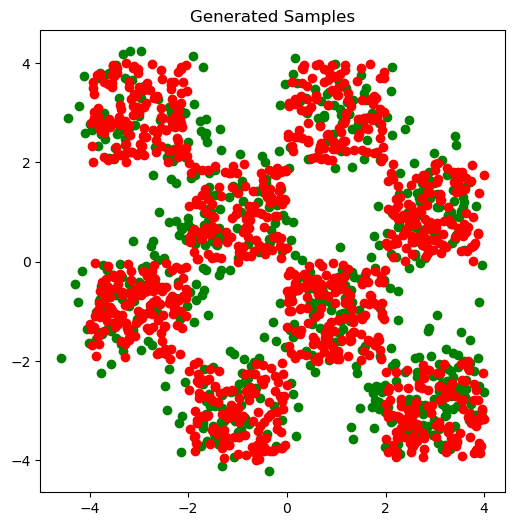

In [112]:
import torch
import torchdiffeq
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_flow(model, x_0, steps=5, method="euler"):
    """
    Uses an ODE solver to integrate the learned velocity field.
    
    model: Neural network predicting v_t(x).
    x_0: Initial noise sample.
    steps: Number of integration steps.
    method: ODE solver method (e.g., "euler", "rk4", "dopri5", "bdf").
    
    Returns: Generated sample x_1.
    """
    def velocity_field(t, x_t):
        """
        Compute velocity at given time step.
        
        - t: Scalar time step.
        - x_t: Tensor of shape (batch_size, dim).
        """
        # Ensure x_t always has shape (batch_size, dim)
        if x_t.ndim == 1:
            x_t = x_t.unsqueeze(0)  # Ensure batch size

        # Ensure t is a tensor of correct shape (batch_size, 1)
        t_tensor = torch.full((x_t.shape[0], 1), t.item(), device=x_t.device, dtype=x_t.dtype)

        # Compute velocity
        v_t = model(x_t, t_tensor)  # Ensure model output matches (batch_size, dim)
        return v_t

    # Define the time grid (descending order for reverse integration)
    t_eval = torch.linspace(0, 1, steps, device=x_0.device)

    # Solve the ODE using the chosen method
    x_trajectory = torchdiffeq.odeint(velocity_field, x_0, t_eval, method=method)

    # Return the final sample (last time step)
    x_1 = x_trajectory[-1]  # Shape: (batch_size, dim)

    return x_1

# Example: Generate samples using Euler method
x_0 = torch.randn(640, 2)  # Start from Gaussian noise
x_sampled = sample_flow(model, x_0, method="rk4")

# Plot the generated samples
plt.figure(figsize=(6, 6))
plt.scatter(x_sampled[:, 0].cpu(), x_sampled[:, 1].cpu(), color="green", marker="o")
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o", label="Real Data")
plt.title("Generated Samples")
plt.show()
